## Modeling - Citation Prediction

In [3]:
# basic
import json
import pdb
import ast
from tqdm import tqdm
from collections import Counter

import numpy as np
import pandas as pd

# plotting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.neural_network import MLPRegressor

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

SEED = 0

/Users/shreyanasa/miniconda3/envs/anc/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [31]:
X = pd.read_csv('./data/input_intermediate1.csv').set_index('id')
X.fillna(0)
X.head()

,publication_date,page_count,title,concepts,abstract,cited_by_count,authorships,host_venue,open_access_is_oa,referenced_works,counts_by_year,publication_month,venue_works,venue_citations,insts,insts_mean_works,insts_mean_citations,authors,authors_mean_works,authors_mean_citations
id,,,,,,,,,,,,,,,,,,,,
W2150066425,2012-06-16,-1,Are we ready for autonomous driving? The KITTI...,"[['C154945302', '0.7994821'], ['C5799516', '0....","Today, visual recognition systems are still ra...",6636,"[['A2182886034', ['I102335020']], ['A216743171...",V4306417987,False,"['W1578985305', 'W1964814179', 'W1968799614', ...","[[2022, 570], [2021, 1427], [2020, 1363], [201...",6,17289,1459066,"['I102335020', 'I102335020']",85487.0,6948506.0,"['A2182886034', 'A2291154966']",282.500000,21755.500000
W2158782408,2012-12-24,-1,MuJoCo: A physics engine for model-based control,"[['C190390380', '0.9146959'], ['C169590947', '...",We describe a new physics engine tailored to m...,2177,"[['A2028747364', ['I201448701']], ['A208642428...",V4306418941,False,"['W154144259', 'W639693478', 'W1992116952', 'W...","[[2022, 155], [2021, 616], [2020, 601], [2019,...",12,19485,295598,"['I201448701', 'I201448701', 'I201448701']",330243.0,37900809.0,"['A2028747364', 'A2086424281', 'A158011298']",74.666667,7714.333333
W2141125852,2012-06-16,-1,Multi-column deep neural networks for image cl...,"[['C190502265', '0.8540422'], ['C41008148', '0...",Traditional methods of computer vision and mac...,1970,"[['A1966905718', ['I2614128279']], ['A23435481...",V4306417987,True,"['W1601963269', 'W1968995181', 'W1987778624', ...","[[2022, 126], [2021, 237], [2020, 269], [2019,...",6,17289,1459066,"['I2614128279', 'I2614128279', 'I2614128279']",1833.0,229438.0,"['A2343548174', 'A2116333191']",294.500000,44196.500000
W2021851106,2012-12-24,-1,A benchmark for the evaluation of RGB-D SLAM s...,"[['C31972630', '0.78334284'], ['C154945302', '...","In this paper, we present a novel benchmark fo...",1888,"[['A2973958393', ['I62916508']], ['A1927103669...",V4306418941,True,"['W1514909517', 'W1556098723', 'W1656165940', ...","[[2022, 132], [2021, 318], [2020, 326], [2019,...",12,19485,295598,"['I62916508', 'I3133089283', 'I3133089283', 'I...",50481.2,3329707.2,"['A343811326', 'A2153496801']",709.000000,25753.000000
W2100960835,2012-01-08,-1,Fairness through awareness,"[['C41008148', '0.59133285'], ['C95623464', '0...","We study fairness in classification, where ind...",1655,"[['A208343995', ['I1290206253']], ['A230163789...",V4306418069,True,"['W178579835', 'W632002811', 'W1599656298', 'W...","[[2022, 229], [2021, 453], [2020, 353], [2019,...",1,0,0,"['I1290206253', 'I4210085935', 'I185261750', '...",126929.4,10680796.0,"['A208343995', 'A2301637896', 'A672707272', 'A...",209.600000,11635.800000


In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128097 entries, W2150066425 to W995713601
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   publication_date        128097 non-null  object 
 1   page_count              128097 non-null  object 
 2   title                   128097 non-null  object 
 3   concepts                128097 non-null  object 
 4   abstract                128097 non-null  object 
 5   cited_by_count          128097 non-null  int64  
 6   authorships             128097 non-null  object 
 7   host_venue              128097 non-null  object 
 8   open_access_is_oa       128097 non-null  bool   
 9   referenced_works        128097 non-null  object 
 10  counts_by_year          128097 non-null  object 
 11  publication_month       128097 non-null  int64  
 12  venue_works             128097 non-null  int64  
 13  venue_citations         128097 non-null  int64  
 14  insts      

### Load Data

In [9]:
def read_data(file_name):
    with open(file_name, 'r') as f:
        data = [ast.literal_eval(result) for result in tqdm(f.readlines())]
    return data

works_ = read_data('./data/data.works.2012.v1.txt')
authors_ = read_data('./data/data.authors.2012.v1.txt')
venues_ = read_data('./data/data.venues.2012.v1.txt')
insts_ = read_data('./data/data.insts.2012.v1.txt')

def flatten(list_of_lists):
    flattened_list = [j 
                      for i in list_of_lists 
                          for j in i]
    return flattened_list

works = pd.DataFrame.from_dict(flatten(works_))
authors = pd.DataFrame.from_dict(flatten(authors_))
venues = pd.DataFrame.from_dict(flatten(venues_))
insts = pd.DataFrame.from_dict(flatten(insts_))

100%|██████████| 241/241 [00:05<00:00, 46.75it/s]


In [17]:
# works
print (works.shape)
works = works.set_index('id')
works.head()

(128097, 15)


,doi,title,type,publication_date,host_venue,open_access_is_oa,open_access_oa_status,authorships,page_count,cited_by_count,concepts,referenced_works,abstract,counts_by_year
id,,,,,,,,,,,,,,
W2150066425,https://doi.org/10.1109/cvpr.2012.6248074,Are we ready for autonomous driving? The KITTI...,proceedings-article,2012-06-16,V4306417987,False,closed,"[[A2182886034, [I102335020]], [A2167431718, [I...",-1,6636,"[[C154945302, 0.7994821], [C5799516, 0.7514366...","[W1578985305, W1964814179, W1968799614, W19903...","Today, visual recognition systems are still ra...","[[2022, 570], [2021, 1427], [2020, 1363], [201..."
W2158782408,https://doi.org/10.1109/iros.2012.6386109,MuJoCo: A physics engine for model-based control,proceedings-article,2012-12-24,V4306418941,False,closed,"[[A2028747364, [I201448701]], [A2086424281, [I...",-1,2177,"[[C190390380, 0.9146959], [C169590947, 0.71768...","[W154144259, W639693478, W1992116952, W2004116...",We describe a new physics engine tailored to m...,"[[2022, 155], [2021, 616], [2020, 601], [2019,..."
W2141125852,https://doi.org/10.1109/cvpr.2012.6248110,Multi-column deep neural networks for image cl...,proceedings-article,2012-06-16,V4306417987,True,green,"[[A1966905718, [I2614128279]], [A2343548174, [...",-1,1970,"[[C190502265, 0.8540422], [C41008148, 0.794758...","[W1601963269, W1968995181, W1987778624, W20268...",Traditional methods of computer vision and mac...,"[[2022, 126], [2021, 237], [2020, 269], [2019,..."
W2021851106,https://doi.org/10.1109/iros.2012.6385773,A benchmark for the evaluation of RGB-D SLAM s...,proceedings-article,2012-12-24,V4306418941,True,green,"[[A2973958393, [I62916508]], [A1927103669, [I3...",-1,1888,"[[C31972630, 0.78334284], [C154945302, 0.75840...","[W1514909517, W1556098723, W1656165940, W19652...","In this paper, we present a novel benchmark fo...","[[2022, 132], [2021, 318], [2020, 326], [2019,..."
W2100960835,https://doi.org/10.1145/2090236.2090255,Fairness through awareness,proceedings-article,2012-01-08,V4306418069,True,green,"[[A208343995, [I1290206253]], [A2301637896, [I...",-1,1655,"[[C41008148, 0.59133285], [C95623464, 0.542300...","[W178579835, W632002811, W1599656298, W1873763...","We study fairness in classification, where ind...","[[2022, 229], [2021, 453], [2020, 353], [2019,..."


### Feature Extraction

In [57]:
df = pd.DataFrame()
# features
df['publication_month'] = works['publication_date'].map(lambda x: int(x.split('-')[1]))
df['open_access_is_oa'] = works['open_access_is_oa']
df['no_of_authors'] = works['authorships'].map(lambda x: len(x))
df['no_of_referenced_works'] = works['referenced_works'].map(len)

# target variable
df['cited_by_count'] = works['cited_by_count']

In [58]:
# venue_works	venue_citations		insts_mean_works	insts_mean_citations		authors_mean_works	authors_mean_citations
df['venue_works'] = X['venue_works']
df['venue_citations'] = X['venue_citations']
df['insts_mean_works'] = X['insts_mean_works'].fillna(0).astype(int)
df['insts_mean_citations'] = X['insts_mean_citations'].fillna(0).astype(int)
df['authors_mean_works'] = X['authors_mean_works'].fillna(0).apply(int)
df['authors_mean_citations'] = X['authors_mean_citations'].fillna(0).apply(int)

In [59]:
df.head()

,publication_month,open_access_is_oa,no_of_authors,no_of_referenced_works,cited_by_count,venue_works,venue_citations,insts_mean_works,insts_mean_citations,authors_mean_works,authors_mean_citations
id,,,,,,,,,,,
W2150066425,6,False,3,31,6636,17289,1459066,85487,6948506,282,21755
W2158782408,12,False,3,11,2177,19485,295598,330243,37900809,74,7714
W2141125852,6,True,3,21,1970,17289,1459066,1833,229438,294,44196
W2021851106,12,True,5,29,1888,19485,295598,50481,3329707,709,25753
W2100960835,1,True,5,16,1655,0,0,126929,10680796,209,11635


In [45]:
# # normalize
# scaler = StandardScaler()
# X_normalized = scaler.fit_transform(X)

### Regression

In [60]:
X = df.drop(columns=['cited_by_count'])
y = df['cited_by_count']
SEED = 0

In [61]:
# regression analysis

def print_metric(metric_name, metric_list):
    mean, std = np.mean(metric_list), np.std(metric_list)
    print (f"  - {metric_name}: {np.round(mean, 3)} +/- {np.round(std, 3)}")
    return

reg_models = {
    'Linear Regression': LinearRegression(),
    # 'GradientBoostingRegressor': GradientBoostingRegressor(),
    # 'SGDRegressor': SGDRegressor(),
    # 'XGBRegressor': XGBRegressor(),
    # 'MLPRegressor': MLPRegressor(random_state=SEED, max_iter=100),
}

for model_name, model in reg_models.items():
    kf = KFold(n_splits=5, random_state=2, shuffle=True)
    train_rmse, test_rmse = [], []
    print (f"{model_name}:")
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_train)
        rmse = mean_squared_error(y_true=y_train, y_pred=y_pred, squared=False)
        train_rmse.append(rmse)

        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)
        test_rmse.append(rmse)

        print_metric('Train RMSE', train_rmse)
        print_metric('Test RMSE', test_rmse)

Linear Regression:
  - Train RMSE: 33.652 +/- 0.0
  - Test RMSE: 23.662 +/- 0.0
  - Train RMSE: 29.762 +/- 3.89
  - Test RMSE: 36.402 +/- 12.74
  - Train RMSE: 30.706 +/- 3.446
  - Test RMSE: 33.928 +/- 10.975
  - Train RMSE: 31.339 +/- 3.179
  - Test RMSE: 31.925 +/- 10.118
  - Train RMSE: 31.761 +/- 2.966
  - Test RMSE: 30.498 +/- 9.489


Feature: 0  Score: ('publication_month', -0.1352743291636584)
Feature: 1  Score: ('open_access_is_oa', 6.0485161343694545)
Feature: 2  Score: ('no_of_authors', 0.5297729545146277)
Feature: 3  Score: ('no_of_referenced_works', 0.3708217803203535)
Feature: 4  Score: ('venue_works', -3.782468542254676e-05)
Feature: 5  Score: ('venue_citations', 3.227872390642636e-05)
Feature: 6  Score: ('insts_mean_works', -2.61016676867639e-05)
Feature: 7  Score: ('insts_mean_citations', 6.326833687151793e-07)
Feature: 8  Score: ('authors_mean_works', -0.022875691142403783)
Feature: 9  Score: ('authors_mean_citations', 0.001213920737889876)


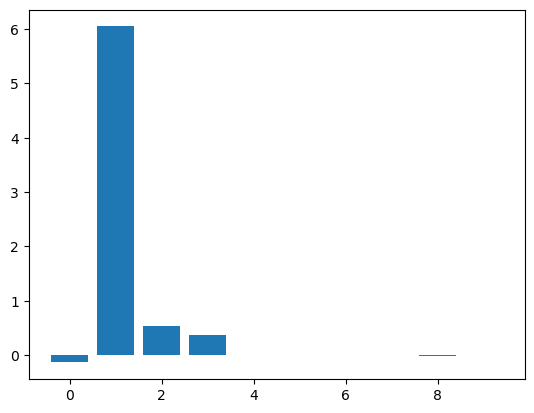

In [62]:
# get importance for linear regression
importance = model.coef_
for i,v in enumerate(zip(X.columns, importance)):
    print('Feature: {}  Score: {}' .format(i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))] ,importance)
plt.show()

### Classification

In [50]:
def bin_citation_count(count):
    if count <= 25:
        return 0
    elif count <= 50:
        return 1
    elif count <= 100:
        return 2
    elif count <= 200:
        return 3
    elif count > 200:
        return 4
    
df['cited_by_count_class'] = df['cited_by_count'].map(bin_citation_count)

In [51]:
X = df.drop(columns=['cited_by_count'])
y = df['cited_by_count_class']

In [52]:
# classification analysis

clf_models = {
    'LogisticRegression': LogisticRegression(n_jobs=-1),
    # 'KNeighborsClassifier': KNeighborsClassifier(n_jobs=-1),
    # 'GaussianNB': GaussianNB(),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(),
    # 'SVC': SVC(random_state=SEED, max_iter=100),
    # 'MLPClassifier': MLPClassifier(random_state=SEED, max_iter=100),
}

for model_name, model in clf_models.items():
    kf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
    train_acc, test_acc = [], []
    train_f1, test_f1 = [], []
    for train_index, test_index in tqdm(kf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_train)
        acc = metrics.accuracy_score(y_true=y_train, y_pred=y_pred)
        f1 = metrics.f1_score(y_true=y_train, y_pred=y_pred, average='weighted')
        train_acc.append(acc*100)
        train_f1.append(f1)

        y_pred = model.predict(X_test)
        acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
        f1 = metrics.f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
        test_acc.append(acc*100)
        test_f1.append(f1)
    print (f"{model_name}:")
    print_metric('Train Accuracy (in %)', train_acc)
    print_metric('Train F1 ', train_f1)
    print_metric('Test Accuracy (in %)', test_acc)
    print_metric('Test F1 ', test_f1)

0it [00:00, ?it/s]/Users/shreyanasa/miniconda3/envs/anc/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/shreyanasa/miniconda3/envs/anc/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
1it [00:18, 18.40s/it]/Users/shreyanasa/miniconda3/envs/anc/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is re

LogisticRegression:
  - Train Accuracy (in %): 93.445 +/- 0.073
  - Train F1 : 0.912 +/- 0.0
  - Test Accuracy (in %): 93.456 +/- 0.112
  - Test F1 : 0.912 +/- 0.001


## rough

<AxesSubplot:xlabel='cited_by_count', ylabel='Count'>

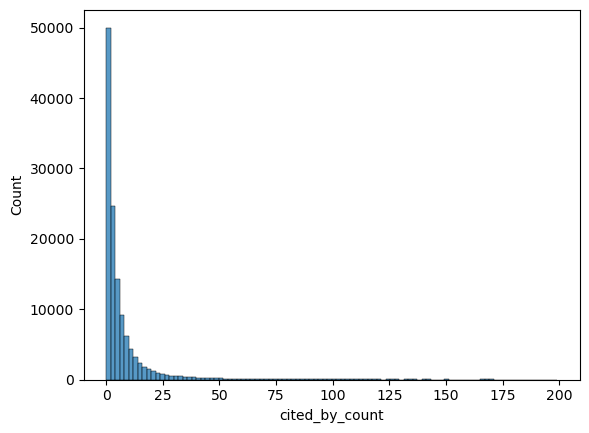

In [33]:
temp = df[df['cited_by_count']<200]
sns.histplot(data=temp, x="cited_by_count", bins=100)

<AxesSubplot:xlabel='cited_by_count', ylabel='Count'>

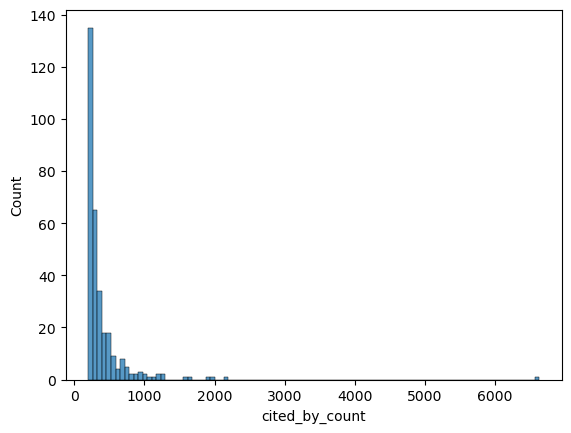

In [38]:
temp = df[df['cited_by_count']>200]
sns.histplot(data=temp, x="cited_by_count", bins=100)